# Analysis of the ISS Movement

## <font color="red">Required packages</font>

- country_converter
- Matplotlib
- NumPy
- Pandas
- Cartopy (might not be needed at the end)
- Shapely
- GeoPandas
- MovingPandas
- HoloViews
- hvplot

<font color="red">If using Google Colab, uncommment the line below</font>

In [ ]:
#!pip install country_converter
#!pip install shapely
#!pip install cartopy
#!pip install geopandas
#!pip install movingpandas
#!pip install holoviews
#!pip install hvplot

---

In [1]:
import warnings 
warnings.filterwarnings("ignore")

In [2]:
import os
from pathlib import Path
import datetime as dt

In [3]:
import country_converter as coco

In [4]:
%matplotlib inline 
import matplotlib 
import matplotlib.pyplot as plt 
import matplotlib.ticker as mticker
import matplotlib.cm as mcm

In [5]:
import cartopy
import cartopy.crs as ccrs 

In [6]:
from shapely import geometry as shpgeom 
from shapely import wkt as shpwkt

In [7]:
import numpy as np
import pandas as pd
import geopandas as gpd
import movingpandas as mpd

In [8]:
import holoviews as hv 
import hvplot.pandas 

In [9]:
#plot_defaults = {'linewidth':5, 'capstyle':'round', 'figsize':(9,3), 'legend':True} 
hv.opts.defaults(hv.opts.Overlay(active_tools=['wheel_zoom'], 
                                 frame_width=620, frame_height=400)) 
hvplot_defaults = {'tiles':None, 'cmap':'Viridis', 'colorbar':True}

In [10]:
mpd.show_versions()


MovingPandas 0.17.1

SYSTEM INFO
-----------
python     : 3.11.4 (main, Jul  5 2023, 08:41:25) [Clang 14.0.6 ]
executable : /Users/jkouatch/miniconda/23.5.2-0_py3.11/2023-09-28/bin/python
machine    : macOS-10.16-x86_64-i386-64bit

GEOS, GDAL, PROJ INFO
---------------------
GEOS       : None
GEOS lib   : None
GDAL       : 3.6.4
GDAL data dir: /Users/jkouatch/miniconda/23.5.2-0_py3.11/2023-09-28/share/gdal
PROJ       : 9.3.0
PROJ data dir: /Users/jkouatch/miniconda/23.5.2-0_py3.11/2023-09-28/share/proj

PYTHON DEPENDENCIES
-------------------
geopandas  : 0.14.0
pandas     : 2.1.1
fiona      : 1.9.3
numpy      : 1.24.4
shapely    : 2.0.1
rtree      : 1.0.1
pyproj     : 3.6.1
matplotlib : 3.8.0
mapclassify: 2.5.0
geopy      : 2.4.0
holoviews  : 1.17.1
hvplot     : 0.8.3
geoviews   : 1.10.1
stonesoup  : None


## Step 1: <font color="red">Read the CSV File</font>

In [11]:
file_name = "iss_timeseries_trajectories_20240211_165733.csv"

In [12]:
df = pd.read_csv(file_name)

In [13]:
df

,t,latitude,longitude,land_flag,temperature,windspeed,traj_id,country
0,2024-02-11 16:57:34,-8.0357,103.8446,False,28.1,3.7,0,Indonesia
1,2024-02-11 16:57:40,-7.7080,104.0832,False,28.0,2.7,0,Indonesia
2,2024-02-11 16:57:46,-7.4053,104.3030,False,28.0,2.2,0,Indonesia
3,2024-02-11 16:57:52,-7.1025,104.5225,False,27.9,3.4,0,Indonesia
4,2024-02-11 16:57:58,-6.7994,104.7418,False,27.8,4.8,0,Indonesia
...,...,...,...,...,...,...,...,...
1996,2024-02-11 20:15:59,29.5914,86.5682,True,-20.0,6.6,2,China
1997,2024-02-11 20:16:05,29.8635,86.8631,True,-23.2,6.4,2,China
1998,2024-02-11 20:16:11,30.1347,87.1596,True,-18.6,3.9,2,China
1999,2024-02-11 20:16:18,30.4274,87.4827,True,-20.5,3.4,2,China


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2001 entries, 0 to 2000
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   t            2001 non-null   object 
 1   latitude     2001 non-null   float64
 2   longitude    2001 non-null   float64
 3   land_flag    2001 non-null   bool   
 4   temperature  2001 non-null   float64
 5   windspeed    2001 non-null   float64
 6   traj_id      2001 non-null   int64  
 7   country      2001 non-null   object 
dtypes: bool(1), float64(4), int64(1), object(2)
memory usage: 111.5+ KB


Note that the column `t` has string as data type. We want it to be a datetime object.

## Step 2: <font color="red">Perform Conversions</font>

#### Convert the `t` column into a datetime object

In [15]:
df['t'] = pd.to_datetime(df['t'], format='%Y-%m-%d %H:%M:%S')

Make the `t` column as index

In [16]:
#df.set_index('t', inplace=True)

In [17]:
df.head(4)

,t,latitude,longitude,land_flag,temperature,windspeed,traj_id,country
0,2024-02-11 16:57:34,-8.0357,103.8446,False,28.1,3.7,0,Indonesia
1,2024-02-11 16:57:40,-7.7080,104.0832,False,28.0,2.7,0,Indonesia
2,2024-02-11 16:57:46,-7.4053,104.3030,False,28.0,2.2,0,Indonesia
3,2024-02-11 16:57:52,-7.1025,104.5225,False,27.9,3.4,0,Indonesia


#### Count the number of locations that are on land:
- `land_flag` is `True` for land and `False` otherwise (ocean).

In [18]:
df.land_flag.sum()

448

#### Convert the positions (latitude and longitude) into `Shapely` POINT objects:
- Add a `geometry` column

In [19]:
df['geometry'] = [shpgeom.Point(xy) for xy in zip(df['longitude'], df['latitude'])] 
df

,t,latitude,longitude,land_flag,temperature,windspeed,traj_id,country,geometry
0,2024-02-11 16:57:34,-8.0357,103.8446,False,28.1,3.7,0,Indonesia,POINT (103.8446 -8.0357)
1,2024-02-11 16:57:40,-7.7080,104.0832,False,28.0,2.7,0,Indonesia,POINT (104.0832 -7.708)
2,2024-02-11 16:57:46,-7.4053,104.3030,False,28.0,2.2,0,Indonesia,POINT (104.303 -7.4053)
3,2024-02-11 16:57:52,-7.1025,104.5225,False,27.9,3.4,0,Indonesia,POINT (104.5225 -7.1025)
4,2024-02-11 16:57:58,-6.7994,104.7418,False,27.8,4.8,0,Indonesia,POINT (104.7418 -6.7994)
...,...,...,...,...,...,...,...,...,...
1996,2024-02-11 20:15:59,29.5914,86.5682,True,-20.0,6.6,2,China,POINT (86.5682 29.5914)
1997,2024-02-11 20:16:05,29.8635,86.8631,True,-23.2,6.4,2,China,POINT (86.8631 29.8635)
1998,2024-02-11 20:16:11,30.1347,87.1596,True,-18.6,3.9,2,China,POINT (87.1596 30.1347)
1999,2024-02-11 20:16:18,30.4274,87.4827,True,-20.5,3.4,2,China,POINT (87.4827 30.4274)


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2001 entries, 0 to 2000
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   t            2001 non-null   datetime64[ns]
 1   latitude     2001 non-null   float64       
 2   longitude    2001 non-null   float64       
 3   land_flag    2001 non-null   bool          
 4   temperature  2001 non-null   float64       
 5   windspeed    2001 non-null   float64       
 6   traj_id      2001 non-null   int64         
 7   country      2001 non-null   object        
 8   geometry     2001 non-null   object        
dtypes: bool(1), datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 127.1+ KB


In [21]:
df.head(4)

,t,latitude,longitude,land_flag,temperature,windspeed,traj_id,country,geometry
0,2024-02-11 16:57:34,-8.0357,103.8446,False,28.1,3.7,0,Indonesia,POINT (103.8446 -8.0357)
1,2024-02-11 16:57:40,-7.7080,104.0832,False,28.0,2.7,0,Indonesia,POINT (104.0832 -7.708)
2,2024-02-11 16:57:46,-7.4053,104.3030,False,28.0,2.2,0,Indonesia,POINT (104.303 -7.4053)
3,2024-02-11 16:57:52,-7.1025,104.5225,False,27.9,3.4,0,Indonesia,POINT (104.5225 -7.1025)


## Step 3: <font color="red">Manipulation with GeoPandas</font>

#### Create a GeoDataFrame

In [22]:
iss_gdf = gpd.GeoDataFrame(df, geometry="geometry") 
iss_gdf

,t,latitude,longitude,land_flag,temperature,windspeed,traj_id,country,geometry
0,2024-02-11 16:57:34,-8.0357,103.8446,False,28.1,3.7,0,Indonesia,POINT (103.84460 -8.03570)
1,2024-02-11 16:57:40,-7.7080,104.0832,False,28.0,2.7,0,Indonesia,POINT (104.08320 -7.70800)
2,2024-02-11 16:57:46,-7.4053,104.3030,False,28.0,2.2,0,Indonesia,POINT (104.30300 -7.40530)
3,2024-02-11 16:57:52,-7.1025,104.5225,False,27.9,3.4,0,Indonesia,POINT (104.52250 -7.10250)
4,2024-02-11 16:57:58,-6.7994,104.7418,False,27.8,4.8,0,Indonesia,POINT (104.74180 -6.79940)
...,...,...,...,...,...,...,...,...,...
1996,2024-02-11 20:15:59,29.5914,86.5682,True,-20.0,6.6,2,China,POINT (86.56820 29.59140)
1997,2024-02-11 20:16:05,29.8635,86.8631,True,-23.2,6.4,2,China,POINT (86.86310 29.86350)
1998,2024-02-11 20:16:11,30.1347,87.1596,True,-18.6,3.9,2,China,POINT (87.15960 30.13470)
1999,2024-02-11 20:16:18,30.4274,87.4827,True,-20.5,3.4,2,China,POINT (87.48270 30.42740)


### <font color="green">Preparing the data</font>

#### Split the paths into two groups: land and ocean

In [23]:
iss_gdf_land = iss_gdf[iss_gdf.land_flag==True]
iss_gdf_ocean = iss_gdf[iss_gdf.land_flag==False]

#### Get the names and acronyms of overpassed countries

In [24]:
country_names = list(iss_gdf_land.country.unique())

In [25]:
out_format = "ISO3"
country_acronyms = [coco.convert(x, to=out_format, not_found=None) for x in country_names]

#### Get the GeoDataFrame of all the countries of the world

This is obtained through the Natural Earth Database background image

In [26]:
gdf_world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

#### From the `gdf_world` GeoDataFrame, extract the overpassed countries only

In [27]:
mask = gdf_world['iso_a3'].isin(country_acronyms)
gdf_country_overpass = gdf_world[mask]
#gdf_country_overpass

#### Compute the centroids of the overpassed countries

In [28]:
gdf_country_overpass['centroid'] = gdf_country_overpass.centroid
#gdf_country_overpass

### <font color="green">Create maps</font>

#### Quick plot of the paths using `Cartopy`

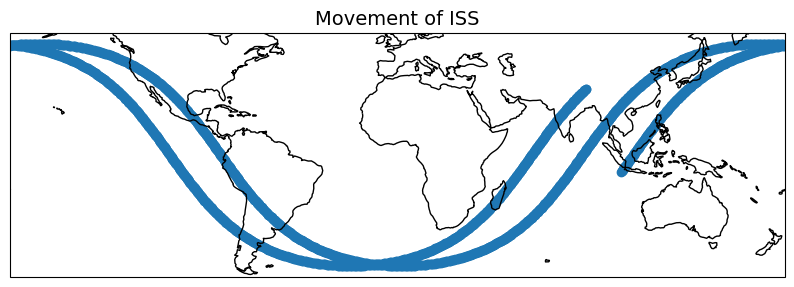

In [29]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_size_inches(10, 10)
iss_gdf.plot(
    ax=ax
)

ax.coastlines()
plt.title('Movement of ISS', fontsize = 14);

#### Plot by country crossed using Cartopy

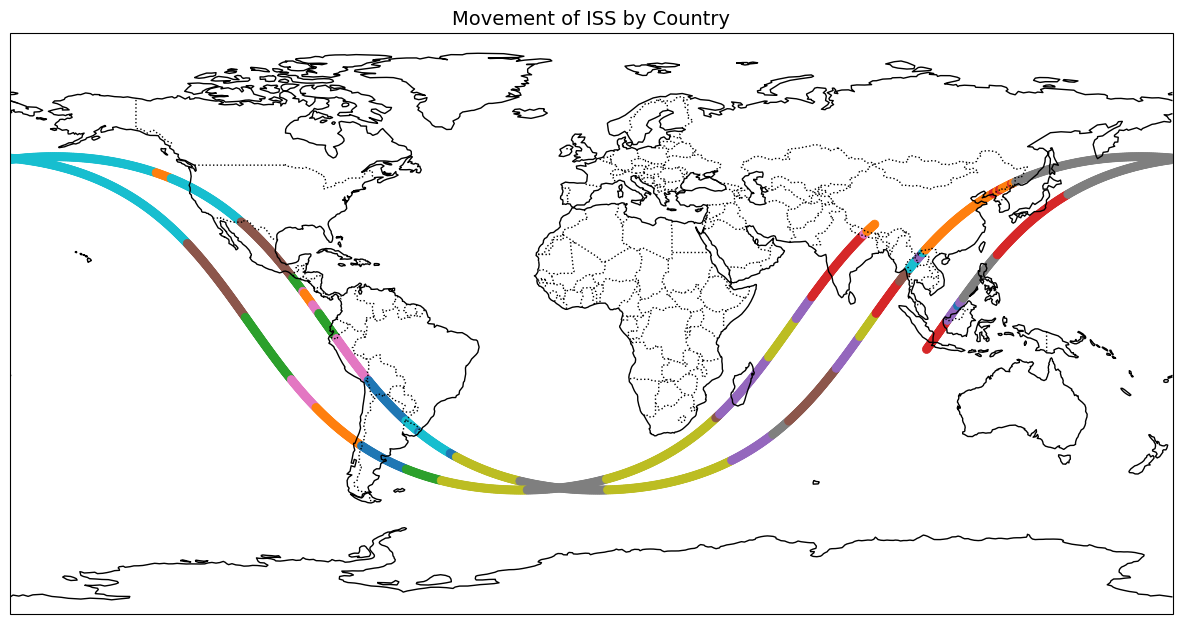

In [30]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_size_inches(15, 10)
iss_gdf.plot(column="country", ax=ax, linewidth=0.5)

ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.coastlines()
ax.set_global()
plt.title('Movement of ISS by Country', fontsize = 14);

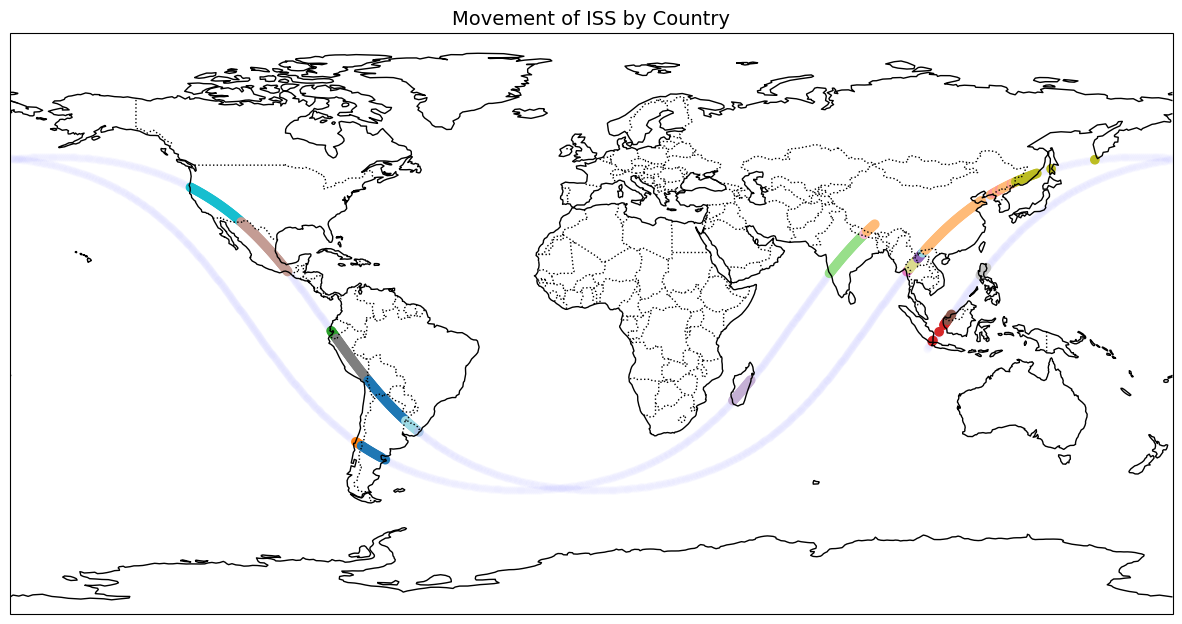

In [31]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_size_inches(15, 10)

iss_gdf_ocean.plot(ax=ax, color="blue", linewidth=0.05, alpha=0.015)
iss_gdf_land.plot(column="country",  ax=ax, cmap=mcm.get_cmap("tab20"))

ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.coastlines()
ax.set_global()
plt.title('Movement of ISS by Country', fontsize = 14);

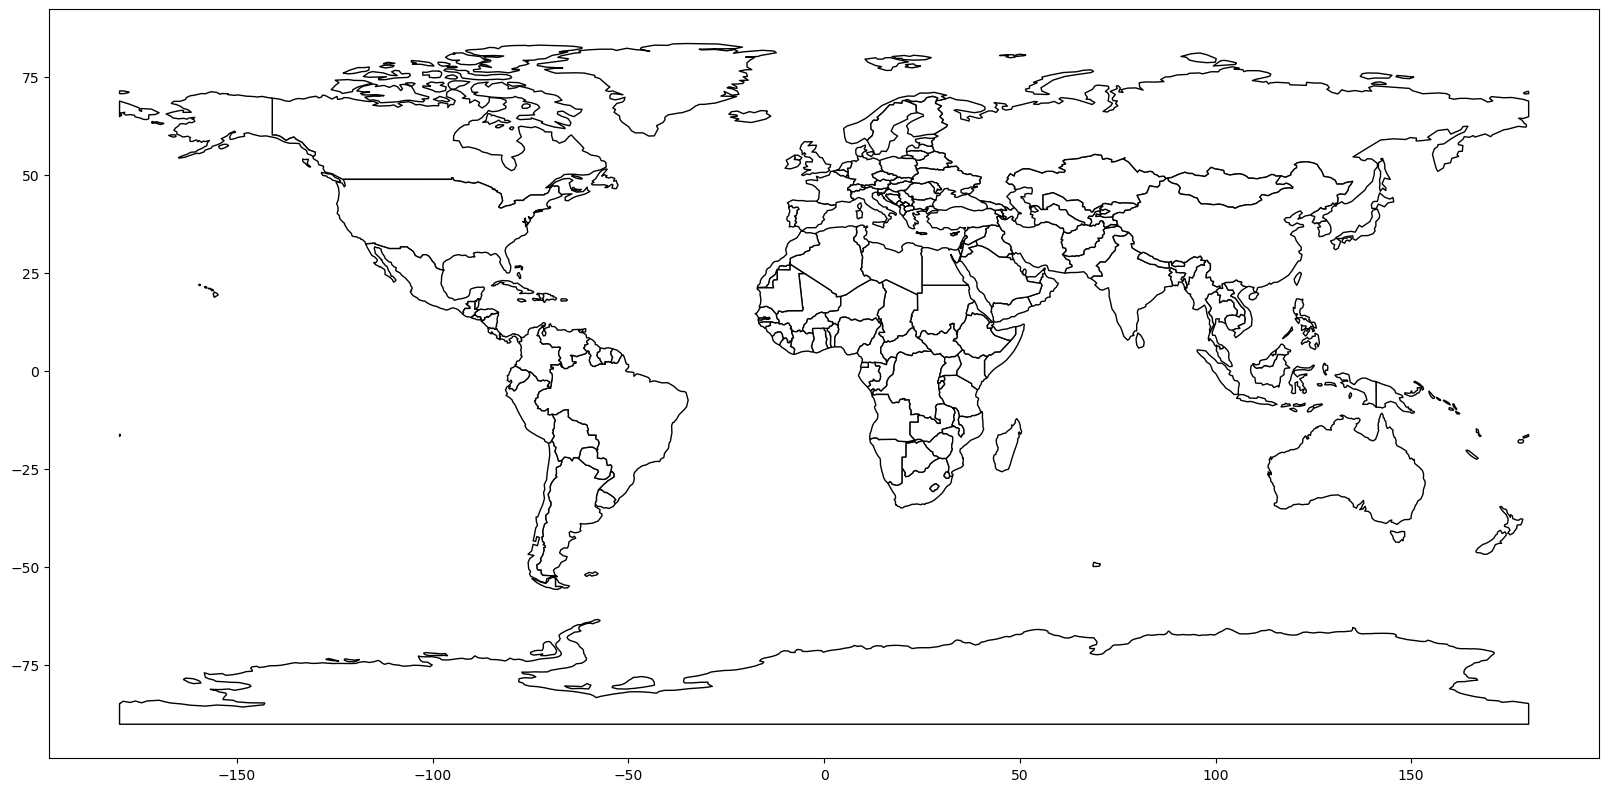

In [32]:
fig, ax = plt.subplots(1, figsize=(20,10))
base = gdf_world.plot(ax=ax, color='white', edgecolor='black',)

#### Map the globe and write the acronyms of overpassed countries

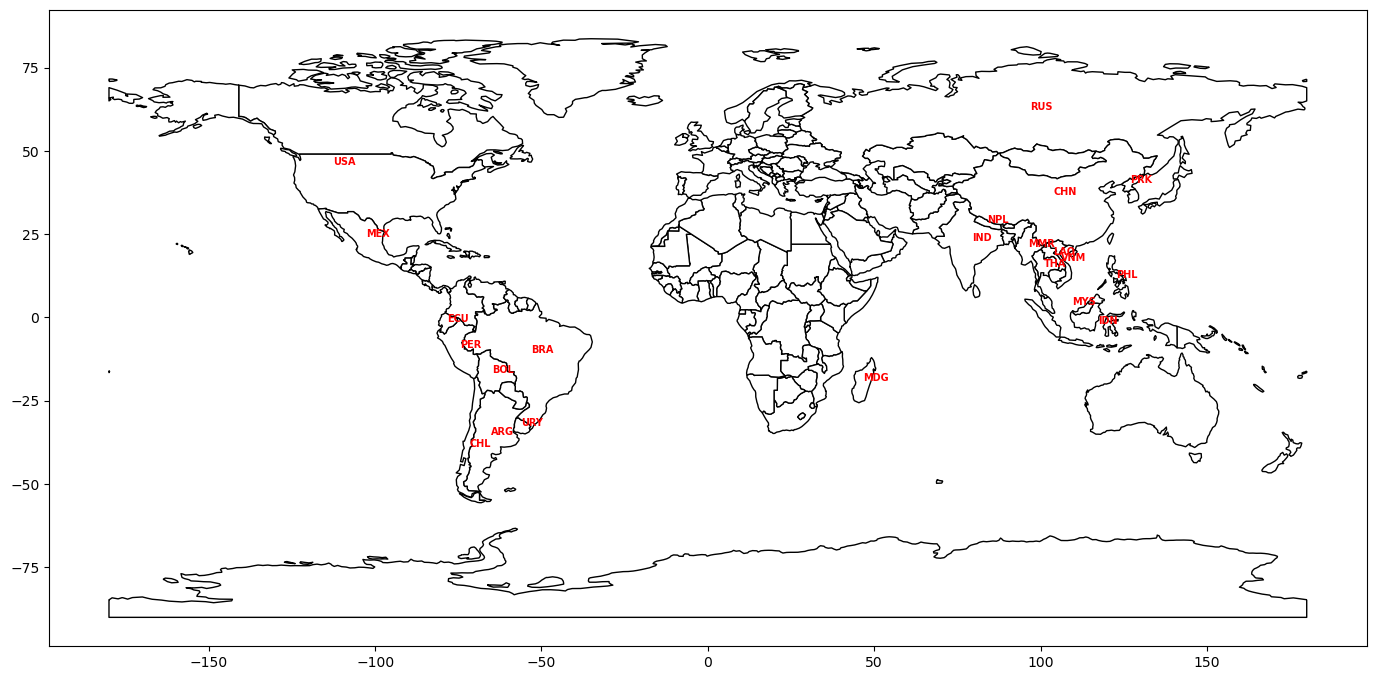

In [33]:
fig, ax = plt.subplots(1,1,figsize=(17,14))
base = gdf_world.plot(ax=ax, color='white', edgecolor='black',)
for x, y, label in zip(gdf_country_overpass.centroid.x, gdf_country_overpass.centroid.y, gdf_country_overpass.iso_a3):
    base.annotate(label, xy=(x, y), xytext=(-0.25, 0.5),
                  color="red",
                  weight="bold",
                  size="7",
                  textcoords="offset points")

#### Map the globe, plot the paths and write the acronyms of overpassed countries

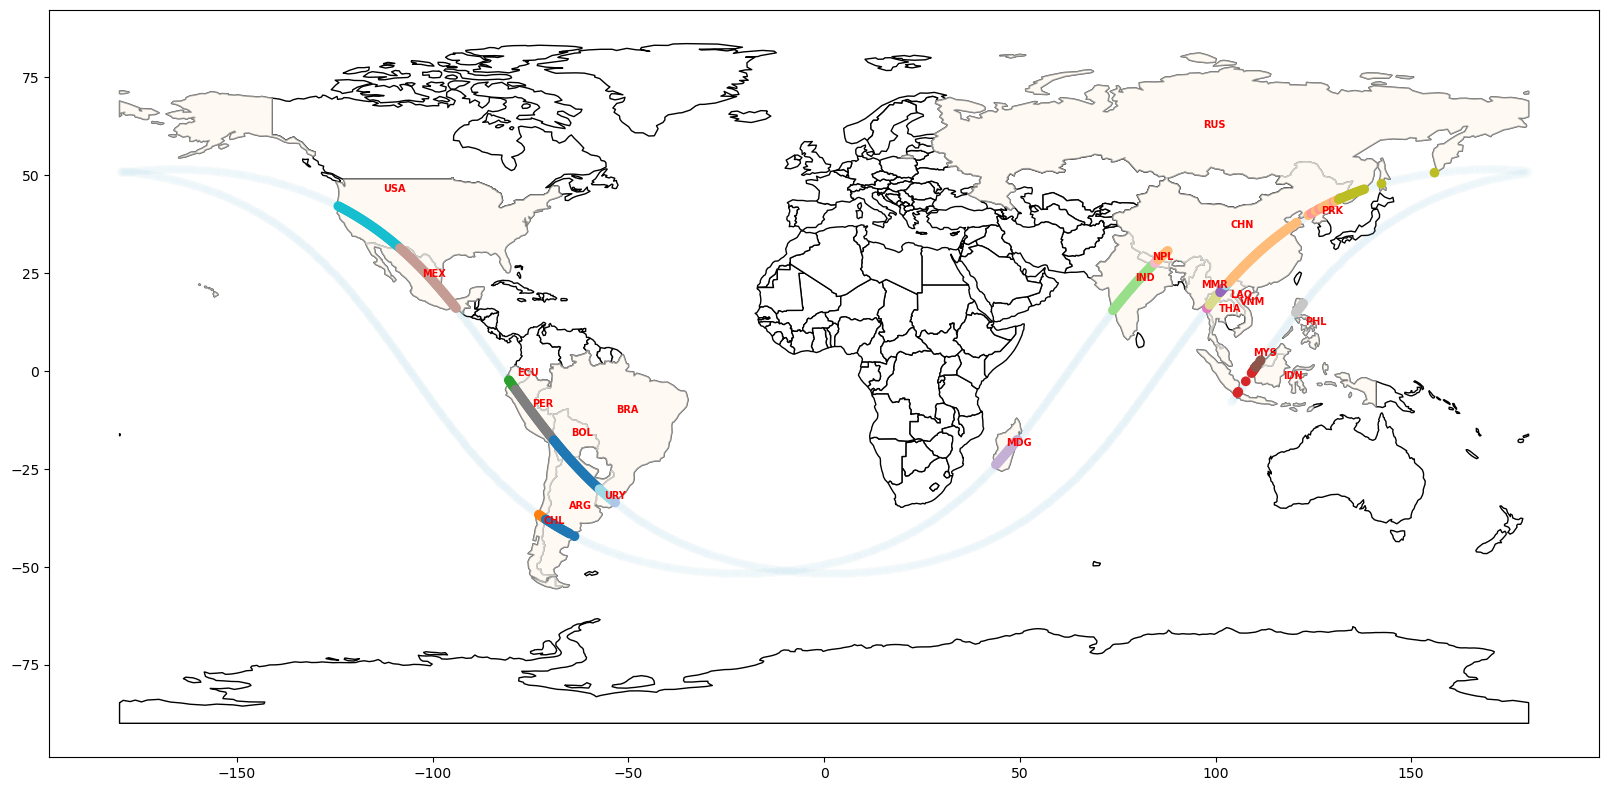

In [34]:
fig, ax = plt.subplots(1, figsize=(20,10))
base = gdf_world.plot(ax=ax, color='white', edgecolor='black',)
gdf_country_overpass.plot(color='oldlace', ax=base, edgecolor='white', alpha=0.45)

iss_gdf_ocean.plot(ax=ax, color="skyblue", linewidth=0.05, alpha=0.035)
iss_gdf_land.plot(column="country",  ax=ax, cmap=mcm.get_cmap("tab20"))


for x, y, label in zip(gdf_country_overpass.centroid.x, gdf_country_overpass.centroid.y, gdf_country_overpass.iso_a3):
    base.annotate(label, xy=(x, y), xytext=(-0.25, 0.5),
                  color="red",
                  weight="bold",
                  size="7",
                  textcoords="offset points")

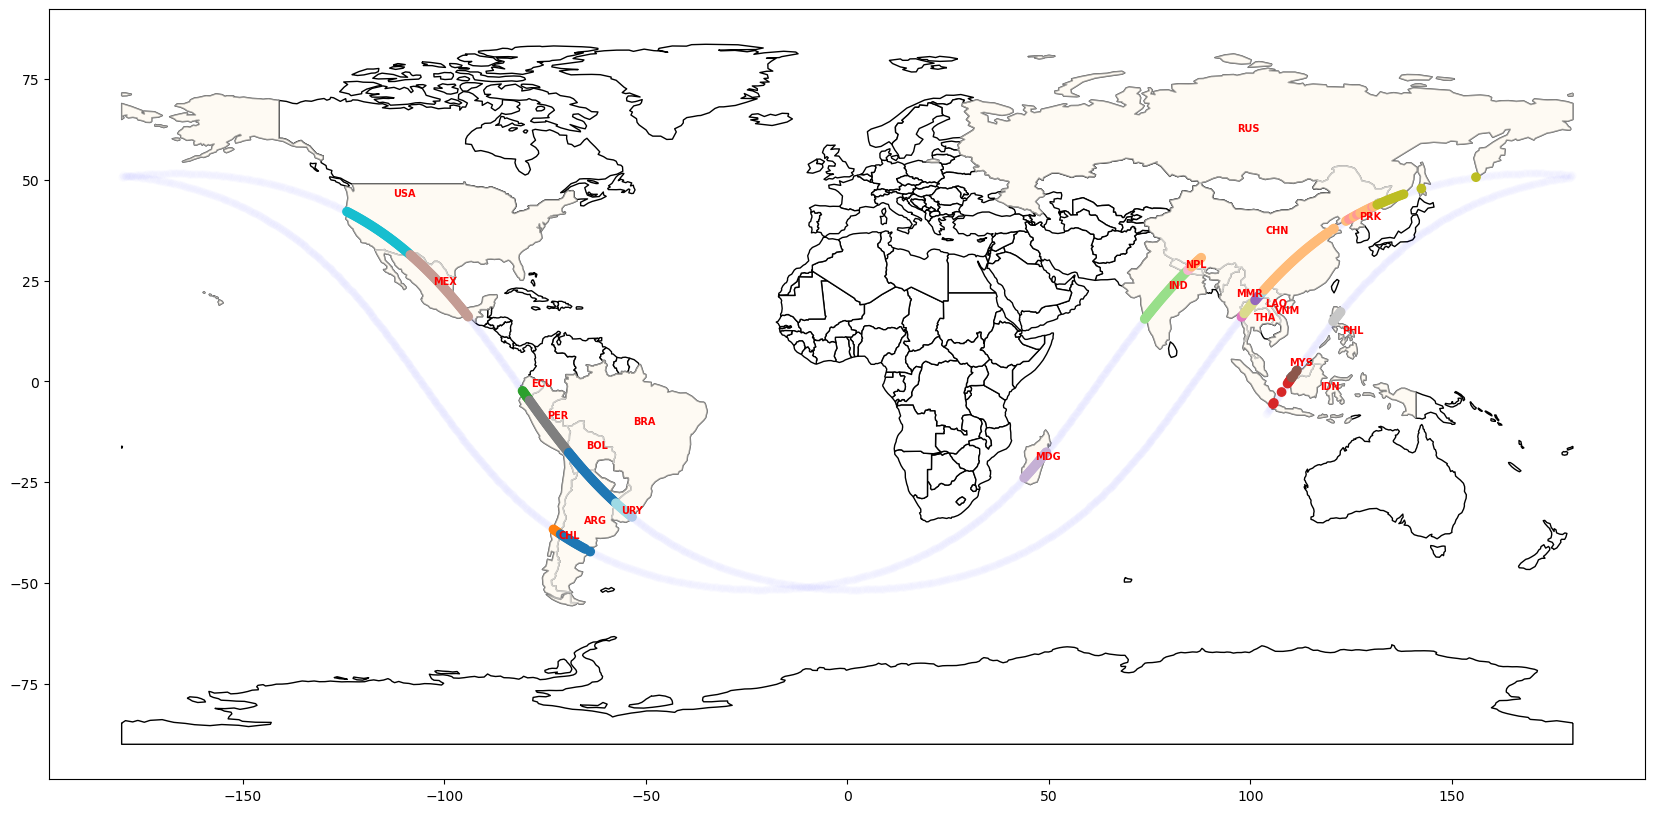

In [35]:
fig, ax = plt.subplots(1, figsize=(25,10))
base = gdf_world.plot(ax=ax, color='white', edgecolor='black',)
gdf_country_overpass.plot(color='oldlace', ax=base, edgecolor='white', alpha=0.45)

iss_gdf_ocean.plot(ax=ax, color="blue", linewidth=0.05, alpha=0.015)
iss_gdf_land.plot(column="country",  ax=ax, cmap=mcm.get_cmap("tab20"))

for x, y, label in zip(gdf_country_overpass.centroid.x, gdf_country_overpass.centroid.y, gdf_country_overpass.iso_a3):
    base.annotate(label, xy=(x, y), xytext=(-0.25, 0.5),
                  color="red",
                  weight="bold",
                  size="7",
                  textcoords="offset points");

# Step 4: Manipulation with MovingPandas

#### Create the MovingPandas trajectories

Create a GeoDataFram by specifying the Coordinate Reference System (CRS)

In [36]:
gdf_path = gpd.GeoDataFrame(df, crs={'init': 'epsg:4326'})

Create the MovingPandas trajectories

In [37]:
iss_trajc = mpd.TrajectoryCollection(gdf_path,
                                 x = "longitude", y="latitude",
                                 traj_id_col="traj_id", t="t")

#### Quick plots

Simple plot with all the trajectories

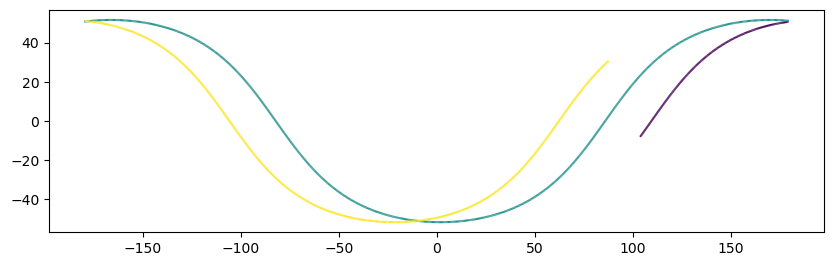

In [38]:
iss_trajc.plot(column='traj_id', figsize=(10,20));

Determine the number of trajectories

In [39]:
num_trajs = len(iss_trajc.trajectories)
print(f"Number of trajectories: {num_trajs}")

Number of trajectories: 3


Plot the individual trajectories

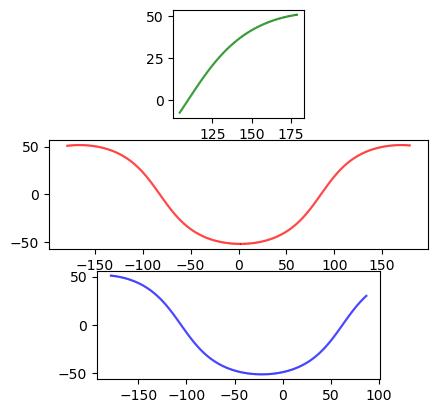

In [40]:
colors = ["green", "red", "blue", "purple"]
fig, ax = plt.subplots(num_trajs, 1)
for i in range(num_trajs):
    iss_trajc.trajectories[i].plot(ax=ax[i], color=colors[i])

#### Include Weather Data

<Axes: >

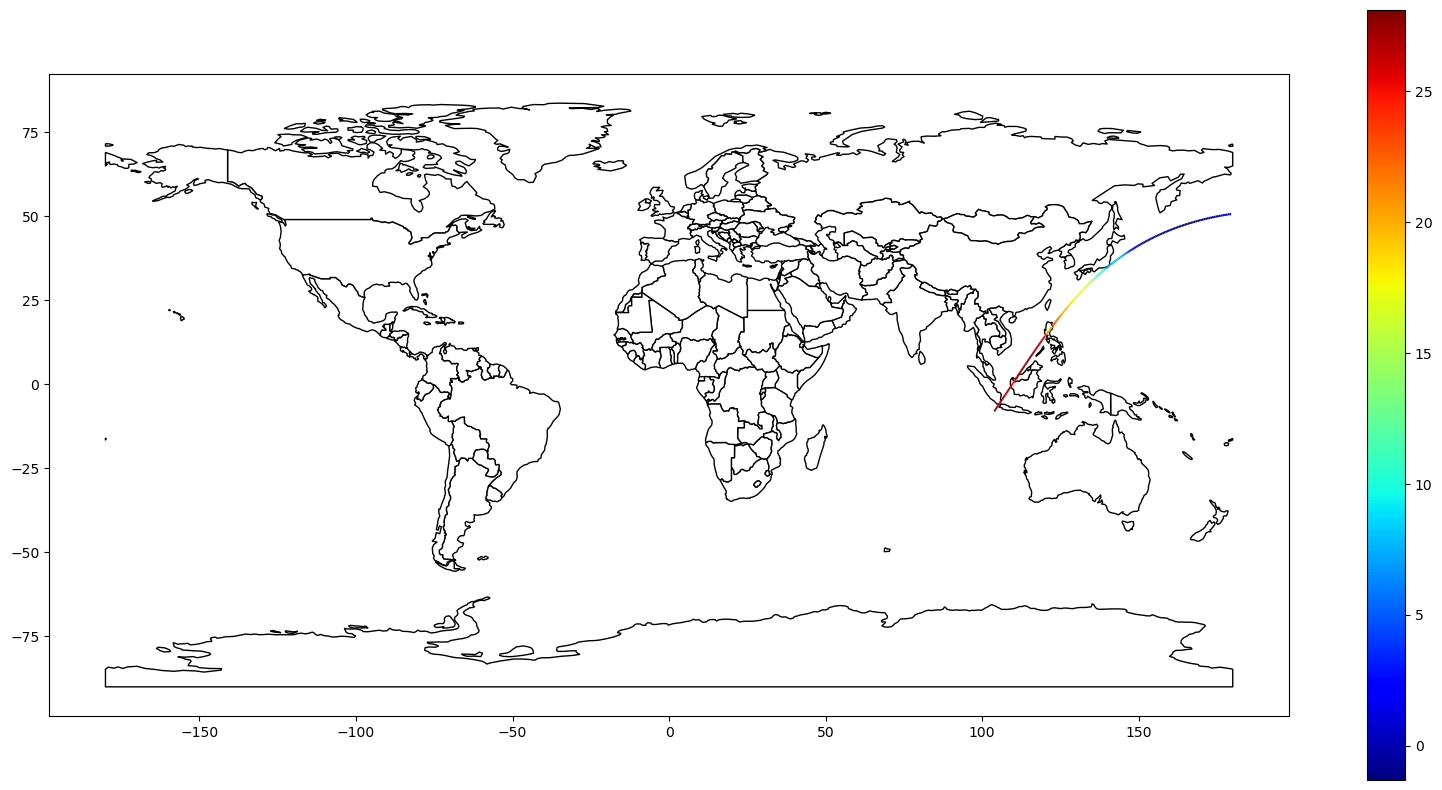

In [41]:
fig, ax = plt.subplots(1, figsize=(20,10))
base = gdf_world.plot(ax=ax, color='white', edgecolor='black',)
iss_trajc.trajectories[0].plot(ax=base, legend="true", column="temperature", cmap='jet')

<Axes: >

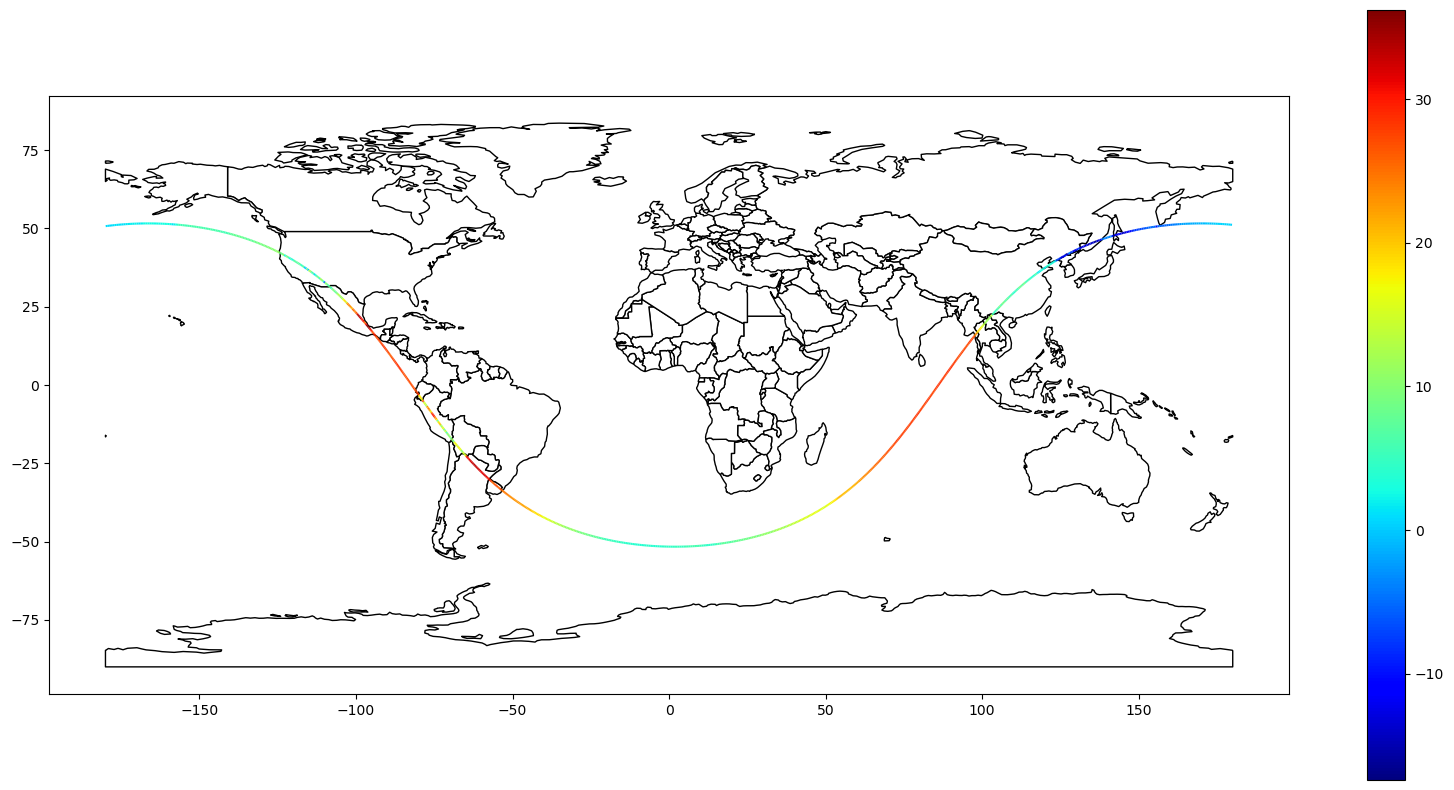

In [42]:
fig, ax = plt.subplots(1, figsize=(20,10))
base = gdf_world.plot(ax=ax, color='white', edgecolor='black',)
iss_trajc.trajectories[1].plot(ax=base, legend="true", column="temperature", cmap='jet')

<Axes: >

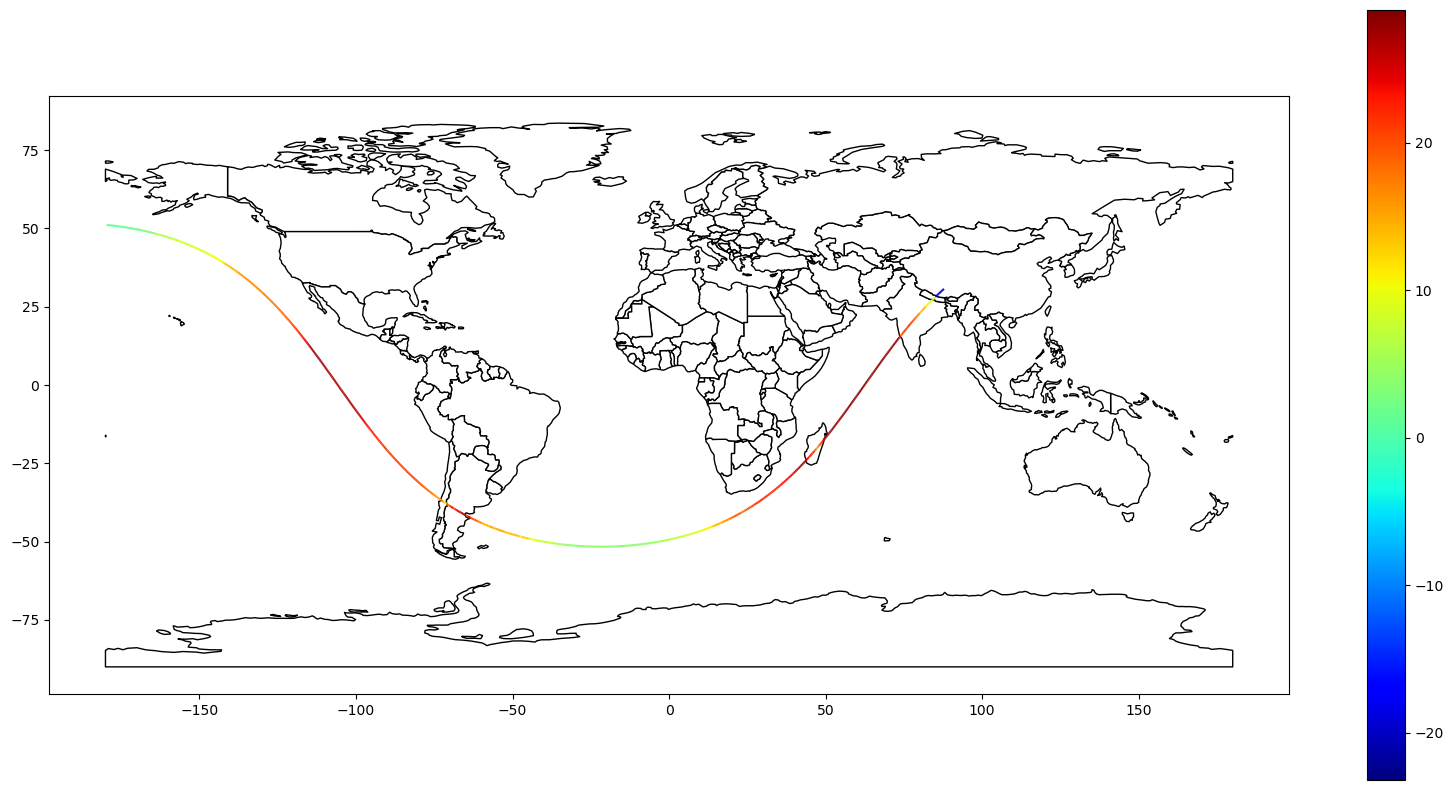

In [43]:
fig, ax = plt.subplots(1, figsize=(20,10))
base = gdf_world.plot(ax=ax, color='white', edgecolor='black',)
iss_trajc.trajectories[2].plot(ax=base, legend="true", column="temperature", cmap='jet')

#### Create interactive plots with weather data

In [44]:
iss_trajc.trajectories[1].hvplot(c="windspeed", tiles="ESRI", cmap="jet")

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Path.I   :Path   [Longitude,Latitude]   (windspeed)
   .Points.I :Points   [Longitude,Latitude]   (windspeed,triangle_angle)

In [45]:
iss_trajc.trajectories[1].hvplot(x='easting', y='northing',
                                 c="temperature", 
                                 hover_cols=['country', 'windspeed'],
                                 tiles="ESRI",
                                 cmap="Set1")

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Path.I   :Path   [easting,northing]   (temperature,country,windspeed)
   .Points.I :Points   [easting,northing]   (temperature,triangle_angle,country,windspeed)

In [46]:
#my_traj = iss_trajc.trajectories[1]
#country = my_traj.df[my_traj.df.land_flag==True].hvplot(c="windspeed", tiles=True, global_extent=True, cmap="jet")
#nocountry = my_traj.df[my_traj.df.land_flag==False].hvplot(tiles=True, global_extent=True, color="yellow")
#nocountry*country
##nocountry

In [47]:
#gdf_path2 = gpd.GeoDataFrame(df[df.land_flag==True], crs={'init': 'epsg:4326'})
#iss_trajc2 = mpd.TrajectoryCollection(gdf_path2,
#                                 x = "longitude", y="latitude",
#                                 traj_id_col="traj_id", t="t")

In [48]:
#iss_trajc2.plot(column='traj_id', figsize=(10,20));